# 3. Рекуррентные нейросети

## Install the ucimlrepo package

In [26]:
!pip install ucimlrepo

## Import the dataset into your code

In [27]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
steel_industry_energy_consumption = fetch_ucirepo(id=851)

# data (as pandas dataframes)
X = steel_industry_energy_consumption.data.features
y = steel_industry_energy_consumption.data.targets

# metadata
print(steel_industry_energy_consumption.metadata)

# variable information
print(steel_industry_energy_consumption.variables)

print(X)
print(y)

print(len([x for x in y["Load_Type"] if x == "Light_Load"]))
print(len([x for x in y["Load_Type"] if x == "Medium_Load"]))
print(len([x for x in y["Load_Type"] if x == "Maximum_Load"]))


{'uci_id': 851, 'name': 'Steel Industry Energy Consumption', 'repository_url': 'https://archive.ics.uci.edu/dataset/851/steel+industry+energy+consumption', 'data_url': 'https://archive.ics.uci.edu/static/public/851/data.csv', 'abstract': 'The data is collected from a smart small-scale steel industry in South Korea.', 'area': 'Physics and Chemistry', 'tasks': ['Regression'], 'characteristics': ['Multivariate'], 'num_instances': 35040, 'num_features': 9, 'feature_types': ['Real', 'Categorical'], 'demographics': [], 'target_col': ['Load_Type'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2021, 'last_updated': 'Mon Aug 14 2023', 'dataset_doi': '10.24432/C52G8C', 'creators': ['Sathishkumar V E', 'Changsun Shin', 'Yongyun Cho'], 'intro_paper': {'title': 'Efficient energy consumption prediction model for a data analytic-enabled industry building in a smart city', 'authors': 'Sathishkumar V E, Changsun Shin, Yongyun Cho', 'published

## Preprocessing

In [28]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

label_encoder = LabelEncoder()
scaler = StandardScaler()
X["WeekStatus"] = label_encoder.fit_transform(X["WeekStatus"])
X["Day_of_week"] = label_encoder.fit_transform(X["Day_of_week"])

y["Load_Type"] = label_encoder.fit_transform(y["Load_Type"])
y = pd.get_dummies(y["Load_Type"]).values

numeric_features = [
    "Usage_kWh",
    "Lagging_Current_Reactive.Power_kVarh",
    "Leading_Current_Reactive_Power_kVarh",
    "CO2(tCO2)",
    "Lagging_Current_Power_Factor",
    "Leading_Current_Power_Factor",
    "NSM",
]
X[numeric_features] = scaler.fit_transform(X[numeric_features])

X.info()

seq_len = 500
X_seq = []
Y_seq = []

for i in range(len(X) - seq_len):
    X_seq.append(X[i : i + seq_len])
    Y_seq.append(y[i + seq_len])

X_seq = np.array(X_seq)
y_seq = np.array(Y_seq)

X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.1)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35040 entries, 0 to 35039
Data columns (total 9 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Usage_kWh                             35040 non-null  float64
 1   Lagging_Current_Reactive.Power_kVarh  35040 non-null  float64
 2   Leading_Current_Reactive_Power_kVarh  35040 non-null  float64
 3   CO2(tCO2)                             35040 non-null  float64
 4   Lagging_Current_Power_Factor          35040 non-null  float64
 5   Leading_Current_Power_Factor          35040 non-null  float64
 6   NSM                                   35040 non-null  float64
 7   WeekStatus                            35040 non-null  int32  
 8   Day_of_week                           35040 non-null  int32  
dtypes: float64(7), int32(2)
memory usage: 2.1 MB


C:\Users\user\AppData\Local\Temp\ipykernel_13684\2867944416.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["WeekStatus"] = label_encoder.fit_transform(X["WeekStatus"])
C:\Users\user\AppData\Local\Temp\ipykernel_13684\2867944416.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["Day_of_week"] = label_encoder.fit_transform(X["Day_of_week"])
C:\Users\user\AppData\Local\Temp\ipykernel_13684\2867944416.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

## RNN

In [29]:
from RNN import RNN, DenseLay, CategoricalCrossEntropy, Model

learning_rate = 0.05
epochs = 30

model = Model(CategoricalCrossEntropy(), learning_rate=learning_rate, epochs=epochs)
model.add_lay(
    RNN(
        input_size=X_test.shape[-1],
        output_size=24,
        return_sequence=True,
        activation="relu",
    )
)
model.add_lay(
    RNN(input_size=24, output_size=10, return_sequence=False, activation="relu")
)
model.add_lay(DenseLay(10, 3, activation="softmax"))

model.train(X_train, y_train, learning_rate=learning_rate)

y_pred = model.predict(X_test)


F1: 0.7923572857146951
Class 0              Precision:0.9230     Recall:0.9957    
Class 1              Precision:0.7351     Recall:0.6719    
Class 2              Precision:0.7517     Recall:0.6854    


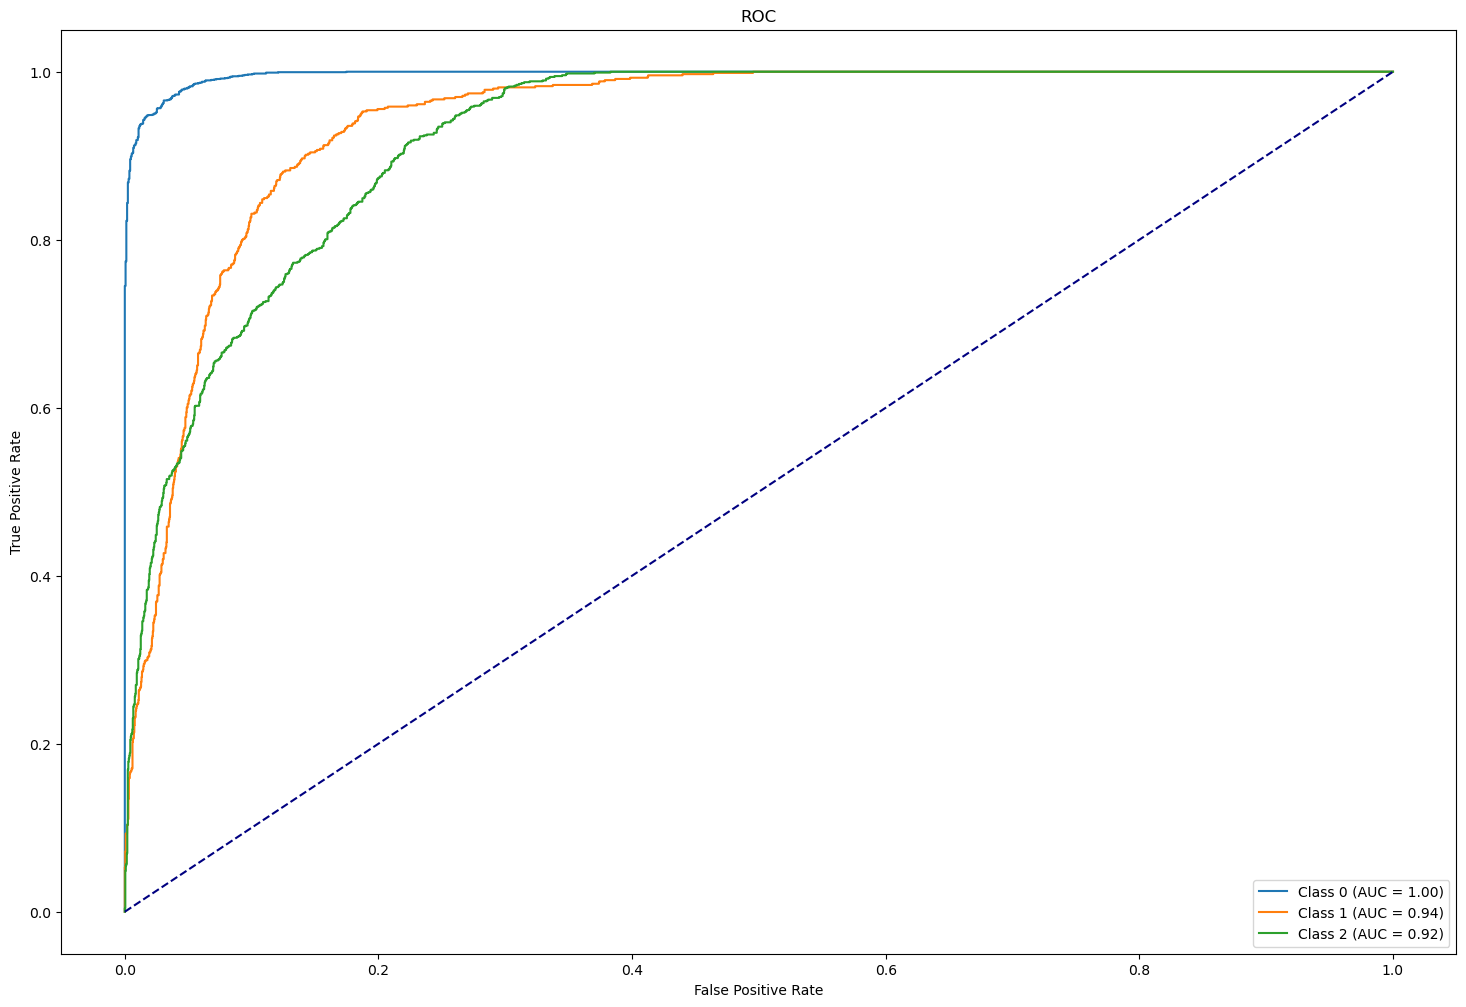

In [30]:
from RNN import precision_recall, auc, roc, F1
from matplotlib import pyplot as plt

f1_score = F1(y_test, y_pred)
print(f"F1: {f1_score}")

precisions, recalls = precision_recall(y_test, y_pred)
target_names = [f"Class {i}" for i in range(len(precisions))]
for i, class_name in enumerate(target_names):
    print(
        "{:<20} Precision:{:<10.4f} Recall:{:<10.4f}".format(
            class_name, precisions[i], recalls[i]
        )
    )

num_classes = y_test.shape[1]
all_fpr = []
all_tpr = []

plt.figure(figsize=(18, 12))
for class_index in range(num_classes):
    fpr, tpr = roc(y_test[:, class_index], y_pred[:, class_index])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label="Class {} (AUC = {:.2f})".format(class_index, roc_auc))
    interpolated_tpr = np.interp(np.linspace(0, 1, 100), fpr, tpr)
    all_fpr.append(np.linspace(0, 1, 100))
    all_tpr.append(interpolated_tpr)

plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC")
plt.legend(loc="lower right")
plt.show()


## LSTM

In [31]:
from RNN import LSTM

learning_rate = 0.05
epochs = 30

model = Model(CategoricalCrossEntropy(), learning_rate=learning_rate, epochs=epochs)
model.add_lay(
    LSTM(
        input_size=X_train.shape[-1],
        output_size=24,
        return_sequence=True,
        activation="relu",
    )
)
model.add_lay(
    LSTM(input_size=24, output_size=16, return_sequence=False, activation="relu")
)
model.add_lay(DenseLay(16, 3, activation="softmax"))
model.train(X_train, y_train, learning_rate=learning_rate)

y_pred = model.predict(X_test)


F1: 0.717824926320264
Class 0              Precision:0.9223     Recall:0.9783    
Class 1              Precision:0.5875     Recall:0.5673    
Class 2              Precision:0.6583     Recall:0.5981    


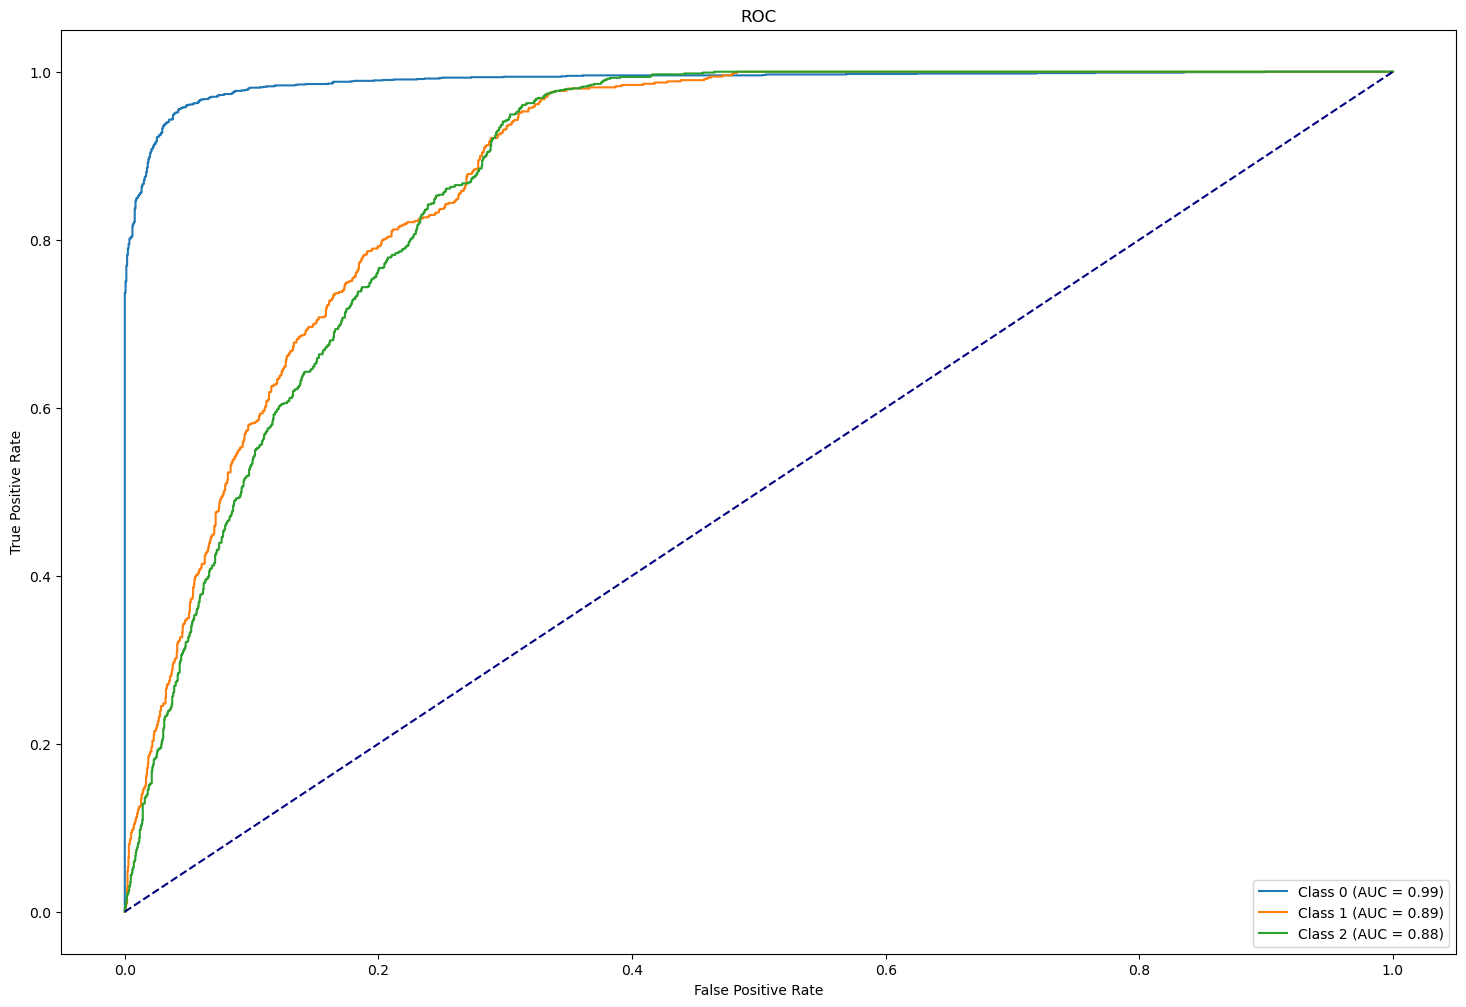

In [32]:
from RNN import precision_recall, auc, roc
from matplotlib import pyplot as plt

f1_score = F1(y_test, y_pred)
print(f"F1: {f1_score}")

precisions, recalls = precision_recall(y_test, y_pred)
target_names = [f"Class {i}" for i in range(len(precisions))]
for i, class_name in enumerate(target_names):
    print(
        "{:<20} Precision:{:<10.4f} Recall:{:<10.4f}".format(
            class_name, precisions[i], recalls[i]
        )
    )


num_classes = y_test.shape[1]
all_fpr = []
all_tpr = []

plt.figure(figsize=(18, 12))
for class_index in range(num_classes):
    fpr, tpr = roc(y_test[:, class_index], y_pred[:, class_index])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label="Class {} (AUC = {:.2f})".format(class_index, roc_auc))
    interpolated_tpr = np.interp(np.linspace(0, 1, 100), fpr, tpr)
    all_fpr.append(np.linspace(0, 1, 100))
    all_tpr.append(interpolated_tpr)

plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC")
plt.legend(loc="lower right")
plt.show()


## GRU

In [33]:
from RNN import GRU

learning_rate = 0.05
epochs = 30

model = Model(CategoricalCrossEntropy(), learning_rate=learning_rate, epochs=epochs)
model.add_lay(
    GRU(
        input_size=X_train.shape[-1],
        output_size=32,
        return_sequence=True,
        activation="relu",
    )
)
model.add_lay(
    GRU(input_size=32, output_size=12, return_sequence=False, activation="relu")
)
model.add_lay(DenseLay(12, 3, activation="softmax"))
model.train(X_train, y_train, learning_rate=learning_rate)

y_pred = model.predict(X_test)


F1: 0.8034414744760415
Class 0              Precision:0.9383     Recall:0.9908    
Class 1              Precision:0.6932     Recall:0.7736    
Class 2              Precision:0.7997     Recall:0.6469    


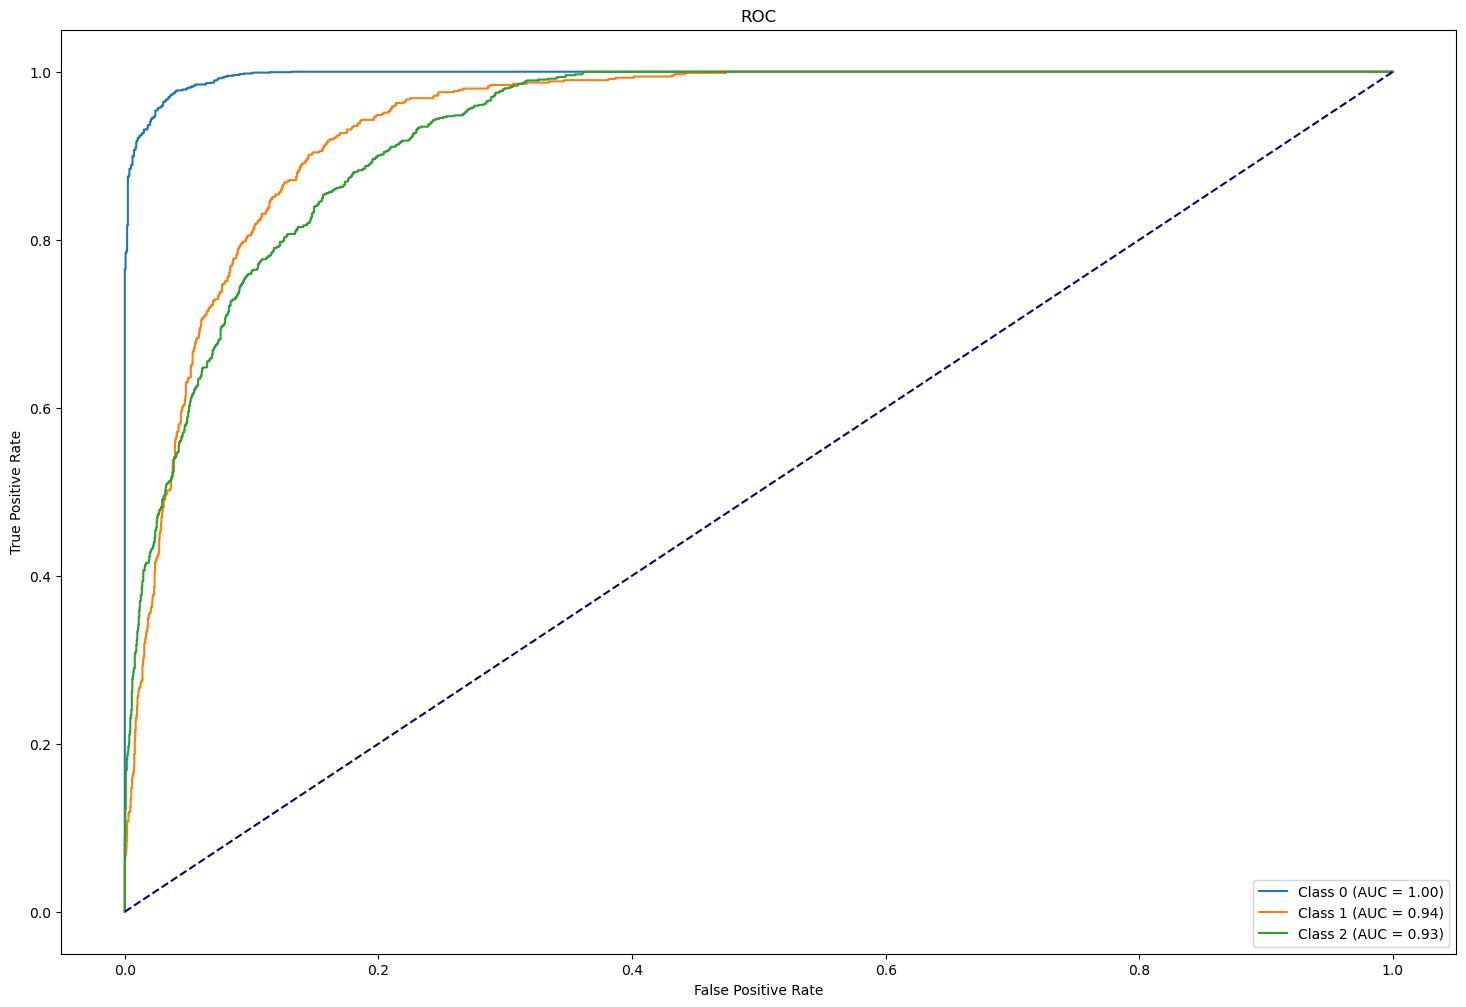

In [34]:
from RNN import precision_recall, auc, roc
from matplotlib import pyplot as plt

f1_score = F1(y_test, y_pred)
print(f"F1: {f1_score}")

precisions, recalls = precision_recall(y_test, y_pred)
target_names = [f"Class {i}" for i in range(len(precisions))]
for i, class_name in enumerate(target_names):
    print(
        "{:<20} Precision:{:<10.4f} Recall:{:<10.4f}".format(
            class_name, precisions[i], recalls[i]
        )
    )


num_classes = y_test.shape[1]
all_fpr = []
all_tpr = []

plt.figure(figsize=(18, 12))
for class_index in range(num_classes):
    fpr, tpr = roc(y_test[:, class_index], y_pred[:, class_index])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label="Class {} (AUC = {:.2f})".format(class_index, roc_auc))
    interpolated_tpr = np.interp(np.linspace(0, 1, 100), fpr, tpr)
    all_fpr.append(np.linspace(0, 1, 100))
    all_tpr.append(interpolated_tpr)

plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC")
plt.legend(loc="lower right")
plt.show()
